In [1]:
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
text_embedder = CohereTextEmbedder(model="embed-multilingual-light-v3.0")

In [2]:
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever

document_store = PineconeDocumentStore(
  index="prototype",
  metric="cosine",
  dimension=384,
  spec={"serverless": {"region": "us-east-1", "cloud": "aws"}},
  )

retriever = PineconeEmbeddingRetriever(document_store=document_store)


/Users/bobbybidon/git/rag-advisor/.conda/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
from haystack.components.builders import PromptBuilder

template = """
En tenant compte des INFORMATIONS suivantes, répond à la QUESTION.

<INFORMATIONS>
{% for document in documents %}
    {{ document.content }}
{% endfor %}
</INFORMATIONS>

<QUESTION> 
{{question}} 
</QUESTION>

Ne jamais mentionner les INFORMATIONS fournies dans la RÉPONSE s'ils ne sont pas lié à la QUESTION. 
Si la question n'est pas compréhensible, ou l'INFORMATIONS n'est pas lié à la question, indiquez que vous n'avez pas l'information pour répondre. 
Répond dans la langue que la QUESTION est posé.
"""

prompt_builder = PromptBuilder(template=template)

In [4]:
from haystack.components.generators import OpenAIGenerator
generator = OpenAIGenerator(model="gpt-4o-mini")

# from haystack_integrations.components.generators.anthropic import AnthropicGenerator
# generator =  AnthropicGenerator(model="claude-3-haiku-20240307")

# from haystack_integrations.components.generators.cohere import CohereGenerator
# generator = CohereGenerator(model="command-light")

In [5]:
from haystack_integrations.components.rankers.cohere import CohereRanker
ranker = CohereRanker(model="rerank-multilingual-v3.0")

In [6]:
from haystack import Pipeline

rag_pipeline = Pipeline()

rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component(instance=ranker, name="ranker")
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "ranker.documents")
rag_pipeline.connect("ranker", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")


🚅 Components
  - text_embedder: CohereTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - ranker: CohereRanker
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [16]:
def run(question):
    response = rag_pipeline.run({"text_embedder": {"text": question}, 
                                "prompt_builder": {"question": question},
                                "retriever": {"top_k": 5},
                                "ranker": {"query": question,
                                        "top_k": 3},
                                })

    return response["llm"]["replies"][0]

In [34]:
qlist = [
    "les meilleurs écouteurs",
    "comment nettoyer ses écouteurs?",
    "critères pour choisir les meilleurs écouteurs?",
    "AUDIO-TECHNICA ATH-M50xBT2",
    "les écouteurs les moins chères",
    "les pires écouteurs",
    "les meilleurs marques d'écouteurs",
    "comment prolonger la durée de vie de mes écouteurs",
    "les meilleurs écouteurs pour la marche",
    "gsffgdsfgdfgdfhfgdhg"
]

rlist = []
for q in qlist:
    r = run(q)
    rlist.append(r)

In [35]:
import pandas as pd
df = pd.DataFrame()
df["question"] = qlist
df["reponse"] = rlist
df

,question,reponse
0,les meilleurs écouteurs,Les meilleurs écouteurs selon les tests inclue...
1,comment nettoyer ses écouteurs?,"Pour nettoyer vos écouteurs, voici quelques ét..."
2,critères pour choisir les meilleurs écouteurs?,"Pour choisir les meilleurs écouteurs, voici le..."
3,AUDIO-TECHNICA ATH-M50xBT2,Les écouteurs AUDIO-TECHNICA ATH-M50xBT2 sont ...
4,les écouteurs les moins chères,Les écouteurs les moins chers mentionnés coûte...
5,les pires écouteurs,Je n'ai pas l'information pour répondre à la q...
6,les meilleurs marques d'écouteurs,Les meilleures marques d'écouteurs incluent So...
7,comment prolonger la durée de vie de mes écout...,Pour prolonger la durée de vie de vos écouteur...
8,les meilleurs écouteurs pour la marche,"Pour la marche, les meilleurs écouteurs seraie..."
9,gsffgdsfgdfgdfhfgdhg,Je n'ai pas l'information pour répondre.


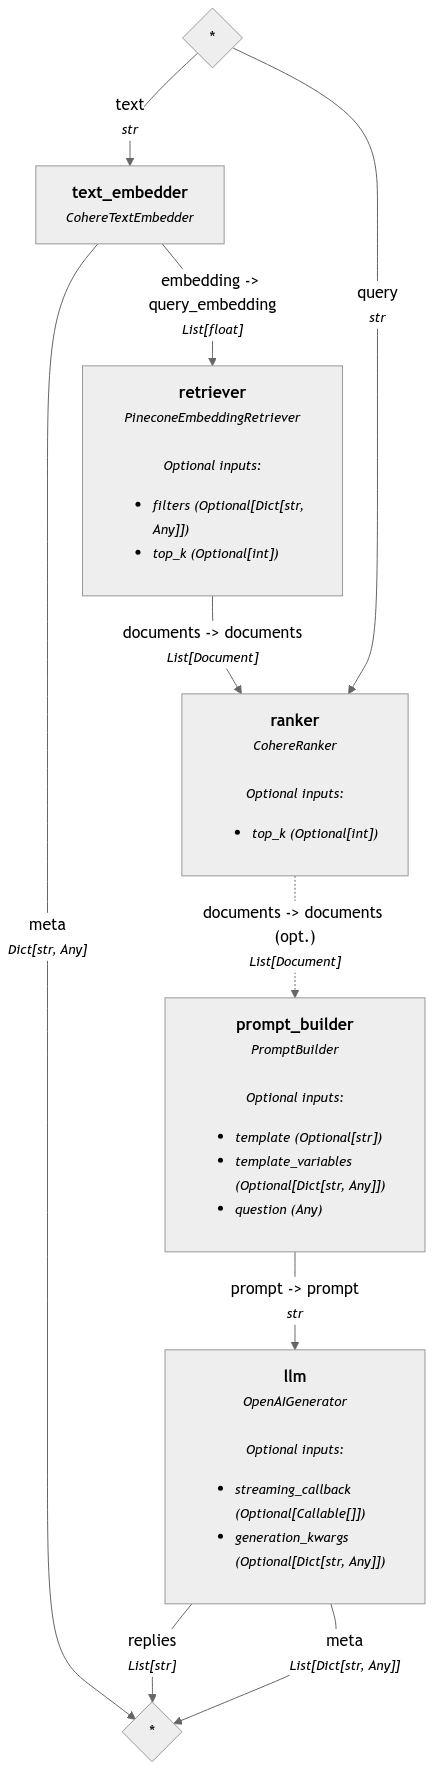

In [8]:
rag_pipeline.show()